# MultiVariate time series forecasting

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from pandas import DataFrame
from pandas import concat
from numpy import concatenate
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from math import sqrt
from datetime import datetime
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 20

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [13]:
data = pd.read_csv('losnavalmoralesFull.csv',sep=';',encoding='utf_16_le' )
#data = pd.read_csv('losnavalmorales.csv',sep=';',encoding='utf_16_le' )  #Version con datos sin tratar, comentar el de arriba

In [14]:
data['Fecha']= pd.to_datetime(data.Fecha, format='%Y/%m/%d')
#dataUpdate =dataUpdate.drop(["IdProvincia","IdEstacion","Año","Dia"],axis=1); # Version con datos sin tratar, descomentar.
cols = data.columns[data.dtypes.eq('object')]
for i in cols:
    data[i] = pd.to_numeric(data[i].str.replace(',', '.'))

data = data.fillna(method='ffill')
data = data.set_index('Fecha');

elementsH = data['Humedad Max (%)'].values
data['Humedad Max (%)'] = [100.0 if elementsH > 100.0 else elementsH for elementsH in elementsH]
elements = data['Precipitación (mm)'].values
elements_ok = [1 if element > 0 else 0 for element in elements]
data['Precipitación (mm)'] = elements_ok
#data['EtPMonAnterior'] = data['EtPMon']
#data['EtPMonAnterior'][1:] = data['EtPMon'][0:-1]
data = data.drop(['Radiación (MJ/m2)','PePMon'],axis=1);

In [15]:
data.dtypes

Temp Media (ºC)       float64
Temp Max (ºC)         float64
Temp Mínima (ºC)      float64
Humedad Media (%)     float64
Humedad Max (%)       float64
Humedad Min (%)       float64
Precipitación (mm)      int64
EtPMon                float64
dtype: object

In [16]:
data.describe()

,Temp Media (ºC),Temp Max (ºC),Temp Mínima (ºC),Humedad Media (%),Humedad Max (%),Humedad Min (%),Precipitación (mm),EtPMon
count,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000
mean,15.158237,20.259489,10.205929,57.103499,74.816678,39.318606,0.249562,3.736802
std,7.980900,9.126262,6.739248,21.753133,19.972338,21.316956,0.432794,2.463768
min,-3.000000,-0.450000,-7.830000,11.610000,15.980000,5.060000,0.000000,0.000000
25%,8.455000,12.325000,4.810000,37.785000,60.205000,20.690000,0.000000,1.490000
50%,13.960000,19.000000,9.260000,58.090000,79.600000,35.560000,0.000000,3.140000
75%,22.090000,28.340000,15.785000,75.800000,92.100000,56.290000,0.000000,5.890000
max,36.070000,41.600000,28.300000,100.000000,100.000000,100.000000,1.000000,10.130000


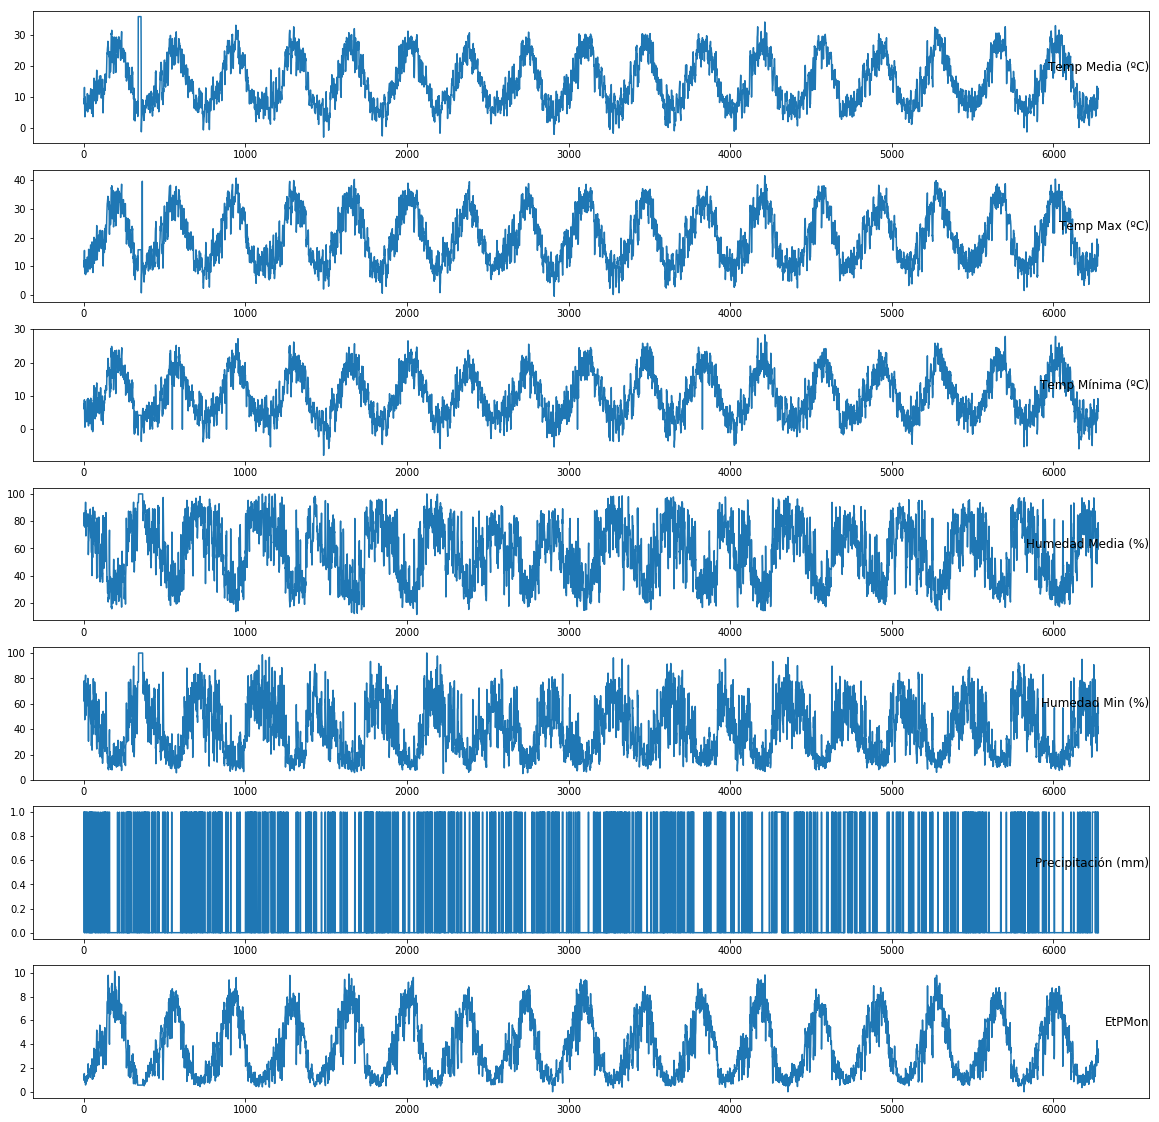

In [17]:
values = data.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [18]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,6] = encoder.fit_transform(values[:,6])
# ensure all data is float
values = values.astype('float32')
# normalize features
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13,14]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       9.36      11.89       7.64  86.000000  95.900002  77.699997   
2       7.78      10.22       6.11  78.800003  92.800003  62.150002   
3       7.90       9.70       6.18  82.300003  90.300003  72.500000   
4      10.25      12.36       8.69  76.300003  88.500000  63.950001   
5      13.12      15.54       8.83  85.699997  94.900002  77.900002   

   var7(t-1)  var8(t-1)  var8(t)  
1        1.0       0.99     1.37  
2        1.0       1.37     1.10  
3        1.0       1.10     1.53  
4        0.0       1.53     1.31  
5        1.0       1.31     1.12  


In [19]:
# split into train and test sets
values = reframed.values
i=0
j=5000
k= 6278
train = values[i:j, :]
test = values[j:k, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5000, 1, 8) (5000,) (1278, 1, 8) (1278,)


In [23]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Train on 5000 samples, validate on 1278 samples
Epoch 1/1000
 - 0s - loss: 1.7830 - val_loss: 1.0614
Epoch 2/1000
 - 0s - loss: 0.9287 - val_loss: 0.8438
Epoch 3/1000
 - 0s - loss: 0.8005 - val_loss: 0.7848
Epoch 4/1000
 - 0s - loss: 0.7618 - val_loss: 0.7612
Epoch 5/1000
 - 0s - loss: 0.7480 - val_loss: 0.7416
Epoch 6/1000
 - 0s - loss: 0.7399 - val_loss: 0.7248
Epoch 7/1000
 - 0s - loss: 0.7281 - val_loss: 0.7070
Epoch 8/1000
 - 0s - loss: 0.7179 - val_loss: 0.6883
Epoch 9/1000
 - 0s - loss: 0.7078 - val_loss: 0.6744
Epoch 10/1000
 - 0s - loss: 0.6975 - val_loss: 0.6623
Epoch 11/1000
 - 0s - loss: 0.6877 - val_loss: 0.6497
Epoch 12/1000
 - 0s - loss: 0.6801 - val_loss: 0.6405
Epoch 13/1000
 - 0s - loss: 0.6716 - val_loss: 0.6275
Epoch 14/1000
 - 0s - loss: 0.6629 - val_loss: 0.6173
Epoch 15/1000
 - 0s - loss: 0.6537 - val_loss: 0.6072
Epoch 16/1000
 - 0s - loss: 0.6505 - val_loss: 0.6022
Epoch 17/1000
 - 0s - loss: 0.6399 - val_loss: 0.5914
Epoch 18/1000
 - 0s - loss: 0.6361 - val_lo

 - 0s - loss: 0.5415 - val_loss: 0.5139
Epoch 152/1000
 - 0s - loss: 0.5522 - val_loss: 0.5099
Epoch 153/1000
 - 0s - loss: 0.5451 - val_loss: 0.5120
Epoch 154/1000
 - 0s - loss: 0.5425 - val_loss: 0.5165
Epoch 155/1000
 - 0s - loss: 0.5499 - val_loss: 0.5056
Epoch 156/1000
 - 0s - loss: 0.5411 - val_loss: 0.5147
Epoch 157/1000
 - 0s - loss: 0.5491 - val_loss: 0.5122
Epoch 158/1000
 - 0s - loss: 0.5433 - val_loss: 0.5210
Epoch 159/1000
 - 0s - loss: 0.5466 - val_loss: 0.5120
Epoch 160/1000
 - 0s - loss: 0.5399 - val_loss: 0.5142
Epoch 161/1000
 - 0s - loss: 0.5484 - val_loss: 0.5140
Epoch 162/1000
 - 0s - loss: 0.5447 - val_loss: 0.5149
Epoch 163/1000
 - 0s - loss: 0.5433 - val_loss: 0.5165
Epoch 164/1000
 - 0s - loss: 0.5401 - val_loss: 0.5201
Epoch 165/1000
 - 0s - loss: 0.5427 - val_loss: 0.5102
Epoch 166/1000
 - 0s - loss: 0.5497 - val_loss: 0.5139
Epoch 167/1000
 - 0s - loss: 0.5420 - val_loss: 0.5199
Epoch 168/1000
 - 0s - loss: 0.5470 - val_loss: 0.5108
Epoch 169/1000
 - 0s - lo

 - 0s - loss: 0.5354 - val_loss: 0.5093
Epoch 301/1000
 - 0s - loss: 0.5339 - val_loss: 0.5168
Epoch 302/1000
 - 0s - loss: 0.5333 - val_loss: 0.5068
Epoch 303/1000
 - 0s - loss: 0.5422 - val_loss: 0.5051
Epoch 304/1000
 - 0s - loss: 0.5308 - val_loss: 0.5078
Epoch 305/1000
 - 0s - loss: 0.5373 - val_loss: 0.5164
Epoch 306/1000
 - 0s - loss: 0.5348 - val_loss: 0.5086
Epoch 307/1000
 - 0s - loss: 0.5394 - val_loss: 0.5154
Epoch 308/1000
 - 0s - loss: 0.5336 - val_loss: 0.5082
Epoch 309/1000
 - 0s - loss: 0.5376 - val_loss: 0.5250
Epoch 310/1000
 - 0s - loss: 0.5334 - val_loss: 0.5074
Epoch 311/1000
 - 0s - loss: 0.5345 - val_loss: 0.5148
Epoch 312/1000
 - 0s - loss: 0.5321 - val_loss: 0.5067
Epoch 313/1000
 - 0s - loss: 0.5358 - val_loss: 0.5164
Epoch 314/1000
 - 0s - loss: 0.5326 - val_loss: 0.5080
Epoch 315/1000
 - 0s - loss: 0.5340 - val_loss: 0.5188
Epoch 316/1000
 - 0s - loss: 0.5341 - val_loss: 0.5104
Epoch 317/1000
 - 0s - loss: 0.5394 - val_loss: 0.5075
Epoch 318/1000
 - 0s - lo

 - 0s - loss: 0.5281 - val_loss: 0.5036
Epoch 450/1000
 - 0s - loss: 0.5271 - val_loss: 0.5116
Epoch 451/1000
 - 0s - loss: 0.5347 - val_loss: 0.5219
Epoch 452/1000
 - 0s - loss: 0.5292 - val_loss: 0.5088
Epoch 453/1000
 - 0s - loss: 0.5298 - val_loss: 0.5052
Epoch 454/1000
 - 0s - loss: 0.5315 - val_loss: 0.5044
Epoch 455/1000
 - 0s - loss: 0.5264 - val_loss: 0.5157
Epoch 456/1000
 - 0s - loss: 0.5279 - val_loss: 0.5149
Epoch 457/1000
 - 0s - loss: 0.5291 - val_loss: 0.5095
Epoch 458/1000
 - 0s - loss: 0.5292 - val_loss: 0.5069
Epoch 459/1000
 - 0s - loss: 0.5251 - val_loss: 0.5272
Epoch 460/1000
 - 0s - loss: 0.5274 - val_loss: 0.5052
Epoch 461/1000
 - 0s - loss: 0.5319 - val_loss: 0.5041
Epoch 462/1000
 - 0s - loss: 0.5277 - val_loss: 0.5036
Epoch 463/1000
 - 0s - loss: 0.5260 - val_loss: 0.5214
Epoch 464/1000
 - 0s - loss: 0.5273 - val_loss: 0.5141
Epoch 465/1000
 - 0s - loss: 0.5260 - val_loss: 0.5110
Epoch 466/1000
 - 0s - loss: 0.5259 - val_loss: 0.5064
Epoch 467/1000
 - 0s - lo

 - 0s - loss: 0.5230 - val_loss: 0.5096
Epoch 599/1000
 - 0s - loss: 0.5215 - val_loss: 0.5161
Epoch 600/1000
 - 0s - loss: 0.5200 - val_loss: 0.5084
Epoch 601/1000
 - 0s - loss: 0.5227 - val_loss: 0.5032
Epoch 602/1000
 - 0s - loss: 0.5284 - val_loss: 0.5213
Epoch 603/1000
 - 0s - loss: 0.5222 - val_loss: 0.5252
Epoch 604/1000
 - 0s - loss: 0.5216 - val_loss: 0.5006
Epoch 605/1000
 - 0s - loss: 0.5229 - val_loss: 0.5133
Epoch 606/1000
 - 0s - loss: 0.5222 - val_loss: 0.5141
Epoch 607/1000
 - 0s - loss: 0.5255 - val_loss: 0.5401
Epoch 608/1000
 - 0s - loss: 0.5232 - val_loss: 0.5067
Epoch 609/1000
 - 0s - loss: 0.5206 - val_loss: 0.5059
Epoch 610/1000
 - 0s - loss: 0.5238 - val_loss: 0.5120
Epoch 611/1000
 - 0s - loss: 0.5215 - val_loss: 0.5003
Epoch 612/1000
 - 0s - loss: 0.5204 - val_loss: 0.5279
Epoch 613/1000
 - 0s - loss: 0.5232 - val_loss: 0.5180
Epoch 614/1000
 - 0s - loss: 0.5244 - val_loss: 0.5097
Epoch 615/1000
 - 0s - loss: 0.5217 - val_loss: 0.5070
Epoch 616/1000
 - 0s - lo

 - 0s - loss: 0.5196 - val_loss: 0.5042
Epoch 748/1000
 - 0s - loss: 0.5192 - val_loss: 0.5138
Epoch 749/1000
 - 0s - loss: 0.5201 - val_loss: 0.5073
Epoch 750/1000
 - 0s - loss: 0.5222 - val_loss: 0.5105
Epoch 751/1000
 - 0s - loss: 0.5178 - val_loss: 0.5058
Epoch 752/1000
 - 0s - loss: 0.5199 - val_loss: 0.4994
Epoch 753/1000
 - 0s - loss: 0.5198 - val_loss: 0.5082
Epoch 754/1000
 - 0s - loss: 0.5190 - val_loss: 0.5108
Epoch 755/1000
 - 0s - loss: 0.5187 - val_loss: 0.5052
Epoch 756/1000
 - 0s - loss: 0.5213 - val_loss: 0.4990
Epoch 757/1000
 - 0s - loss: 0.5183 - val_loss: 0.5157
Epoch 758/1000
 - 0s - loss: 0.5203 - val_loss: 0.5008
Epoch 759/1000
 - 0s - loss: 0.5188 - val_loss: 0.5080
Epoch 760/1000
 - 0s - loss: 0.5183 - val_loss: 0.5079
Epoch 761/1000
 - 0s - loss: 0.5184 - val_loss: 0.5016
Epoch 762/1000
 - 0s - loss: 0.5187 - val_loss: 0.5041
Epoch 763/1000
 - 0s - loss: 0.5224 - val_loss: 0.5102
Epoch 764/1000
 - 0s - loss: 0.5216 - val_loss: 0.5034
Epoch 765/1000
 - 0s - lo

 - 0s - loss: 0.5156 - val_loss: 0.5149
Epoch 897/1000
 - 0s - loss: 0.5147 - val_loss: 0.5089
Epoch 898/1000
 - 0s - loss: 0.5178 - val_loss: 0.5093
Epoch 899/1000
 - 0s - loss: 0.5162 - val_loss: 0.5039
Epoch 900/1000
 - 0s - loss: 0.5171 - val_loss: 0.5090
Epoch 901/1000
 - 0s - loss: 0.5165 - val_loss: 0.4995
Epoch 902/1000
 - 0s - loss: 0.5167 - val_loss: 0.5103
Epoch 903/1000
 - 0s - loss: 0.5187 - val_loss: 0.5063
Epoch 904/1000
 - 0s - loss: 0.5167 - val_loss: 0.5033
Epoch 905/1000
 - 0s - loss: 0.5151 - val_loss: 0.5052
Epoch 906/1000
 - 0s - loss: 0.5183 - val_loss: 0.5017
Epoch 907/1000
 - 0s - loss: 0.5192 - val_loss: 0.5119
Epoch 908/1000
 - 0s - loss: 0.5155 - val_loss: 0.5053
Epoch 909/1000
 - 0s - loss: 0.5160 - val_loss: 0.5081
Epoch 910/1000
 - 0s - loss: 0.5138 - val_loss: 0.5030
Epoch 911/1000
 - 0s - loss: 0.5146 - val_loss: 0.5048
Epoch 912/1000
 - 0s - loss: 0.5135 - val_loss: 0.5037
Epoch 913/1000
 - 0s - loss: 0.5165 - val_loss: 0.5204
Epoch 914/1000
 - 0s - lo

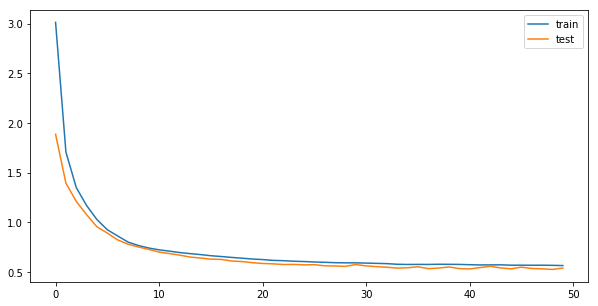

In [21]:
rcParams['figure.figsize'] = 10, 5
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [22]:
# make a prediction
yhat = model.predict(test_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.741
